# Calculate the missing converted MMSEs using bert

In [62]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel

## Data preparation

In [63]:
df = pd.read_csv('Calculate_Word_Count_Total_Wait_Time.csv')
df.describe()

,Age,Word_Count_CTD,Total_Wait_Time_CTD,Word_Count_PFT,Total_Wait_Time_PFT,Word_Count_SFT,Total_Wait_Time_SFT,Converted-MMSE
count,157.00000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,69.000000
mean,65.77707,157.433121,7.917197,32.694268,26.509554,49.292994,18.254777,27.362319
std,12.29634,91.043120,8.103467,15.931610,10.884368,21.727998,9.684712,2.467262
min,23.00000,12.000000,0.000000,8.000000,4.000000,16.000000,1.000000,19.000000
25%,62.00000,90.000000,2.000000,21.000000,18.000000,33.000000,12.000000,27.000000
50%,66.00000,135.000000,5.000000,30.000000,26.000000,45.000000,17.000000,28.000000
75%,72.00000,200.000000,11.000000,41.000000,35.000000,61.000000,24.000000,29.000000
max,94.00000,461.000000,39.000000,89.000000,51.000000,120.000000,46.000000,30.000000


### Select needed columns

In [64]:
# Fix column order
final_columns = [ "Record-ID", "TrainOrDev", "Class", "Gender", "Age", "Word_Count_CTD", "Total_Wait_Time_CTD", "Converted-MMSE" ]
df = df[final_columns]
df

,Record-ID,TrainOrDev,Class,Gender,Age,Word_Count_CTD,Total_Wait_Time_CTD,Converted-MMSE
0,Process-rec-001,train,MCI,male,62.0,210.0,3.0,25.0
1,Process-rec-002,dev,MCI,male,61.0,69.0,14.0,25.0
2,Process-rec-003,train,MCI,female,62.0,143.0,3.0,29.0
3,Process-rec-004,dev,MCI,female,67.0,161.0,2.0,29.0
4,Process-rec-005,train,MCI,male,65.0,45.0,0.0,27.0
...,...,...,...,...,...,...,...,...
152,Process-rec-153,train,HC,male,63.0,112.0,0.0,28.0
153,Process-rec-154,train,HC,female,79.0,222.0,4.0,30.0
154,Process-rec-155,train,HC,male,86.0,91.0,0.0,29.0
155,Process-rec-156,train,Dementia,male,61.0,48.0,16.0,26.0


In [65]:
# split in training and testing
train_df = df[df['Converted-MMSE'].notna()]
test_df = df[df['Converted-MMSE'].isna()]

## Model training

In [66]:
# Load BERT Tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [67]:
# Regression model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

In [68]:
# Tokenization of texts and calculation of hidden states
train_texts = list(train_df['Word_Count_CTD'].astype(str))
inputs = tokenizer(train_texts, return_tensors = "pt", padding = True, truncation = True)
outputs = model(**inputs)
hidden_states = outputs.last_hidden_state.mean(dim = 1)

In [69]:
# Establish the model
regression_model = RegressionModel(hidden_states.size(1))

# Define loss funktion
criterion = nn.MSELoss()

In [70]:
# Training of the model
epochs = 50
learning_rate = 5e-4
optimizer = optim.Adam(regression_model.parameters(), lr = learning_rate)

# List to save the loss values
loss_values = []

for epoch in range(epochs):
    regression_model.train()
    optimizer.zero_grad()
    
    # Calculate hidden statesf for each batch within the epoche
    inputs = tokenizer(list(train_df['Word_Count_CTD'].astype(str)), return_tensors = "pt", padding = True, truncation = True)
    outputs = model(**inputs)
    hidden_states = outputs.last_hidden_state.mean(dim = 1)
    
    outputs = regression_model(hidden_states)
    loss = criterion(outputs.squeeze(), torch.tensor(train_df['Converted-MMSE'].values, dtype=torch.float32))
    loss.backward()
    optimizer.step()

    # save loss value of latest epoch
    loss_values.append(loss.item())

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 1/50, Loss: 752.8924560546875
Epoch 2/50, Loss: 748.1975708007812
Epoch 3/50, Loss: 743.5181274414062
Epoch 4/50, Loss: 738.8540649414062
Epoch 5/50, Loss: 734.2056884765625
Epoch 6/50, Loss: 729.5733642578125
Epoch 7/50, Loss: 724.9570922851562
Epoch 8/50, Loss: 720.3573608398438
Epoch 9/50, Loss: 715.7743530273438
Epoch 10/50, Loss: 711.2081298828125
Epoch 11/50, Loss: 706.6591186523438
Epoch 12/50, Loss: 702.1275024414062
Epoch 13/50, Loss: 697.6133422851562
Epoch 14/50, Loss: 693.116943359375
Epoch 15/50, Loss: 688.6386108398438
Epoch 16/50, Loss: 684.1782836914062
Epoch 17/50, Loss: 679.7362060546875
Epoch 18/50, Loss: 675.3126220703125
Epoch 19/50, Loss: 670.9076538085938
Epoch 20/50, Loss: 666.521484375
Epoch 21/50, Loss: 662.1541748046875
Epoch 22/50, Loss: 657.805908203125
Epoch 23/50, Loss: 653.4768676757812
Epoch 24/50, Loss: 649.1668701171875
Epoch 25/50, Loss: 644.8765258789062
Epoch 26/50, Loss: 640.6055297851562
Epoch 27/50, Loss: 636.3541259765625
Epoch 28/50, Los

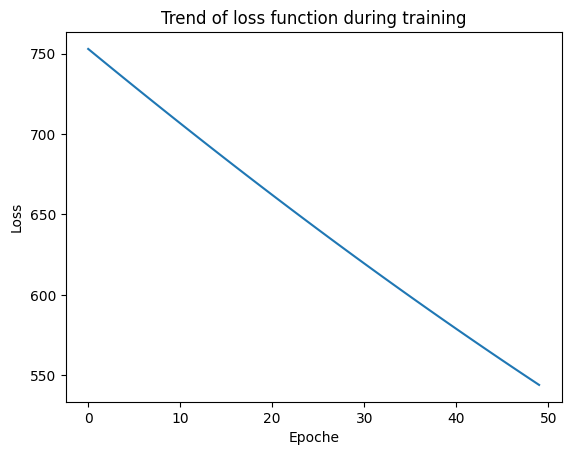

In [71]:
# Plot loss function
plt.plot(range(epochs), loss_values)
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Trend of loss function during training')
plt.show()

## Calculating missing MMSE values

In [72]:
# Tokenization of test tests and calculate predictions
test_texts = list(test_df['Word_Count_CTD'].astype(str))
test_inputs = tokenizer(test_texts, return_tensors = "pt", padding = True, truncation = True)

with torch.no_grad():
    test_hidden_states = model(**test_inputs).last_hidden_state.mean(dim = 1)
    predictions = regression_model(test_hidden_states).squeeze().numpy()

In [76]:
# Min-Max-Scalar
min_pred = predictions.min()
max_pred = predictions.max()

# target range
min_target = 19
max_target = 30

# Scale value to a scope of 10 - 40 and round to int64
scaled_predictions = min_target + (predictions - min_pred) * (max_target - min_target) / (max_pred - min_pred)
rounded_predictions = np.round(scaled_predictions).astype(int)

In [77]:
# Make a copy of the original DataFrame df, to see all tuples
results_df = df.copy()

# Add the predictions to the original data, based on the Record-IDs
results_df.loc[results_df['Converted-MMSE'].isna(), 'Converted-MMSE'] = rounded_predictions

results_df

,Record-ID,TrainOrDev,Class,Gender,Age,Word_Count_CTD,Total_Wait_Time_CTD,Converted-MMSE
0,Process-rec-001,train,MCI,male,62.0,210.0,3.0,25.0
1,Process-rec-002,dev,MCI,male,61.0,69.0,14.0,25.0
2,Process-rec-003,train,MCI,female,62.0,143.0,3.0,29.0
3,Process-rec-004,dev,MCI,female,67.0,161.0,2.0,29.0
4,Process-rec-005,train,MCI,male,65.0,45.0,0.0,27.0
...,...,...,...,...,...,...,...,...
152,Process-rec-153,train,HC,male,63.0,112.0,0.0,28.0
153,Process-rec-154,train,HC,female,79.0,222.0,4.0,30.0
154,Process-rec-155,train,HC,male,86.0,91.0,0.0,29.0
155,Process-rec-156,train,Dementia,male,61.0,48.0,16.0,26.0


In [78]:
# Save table with filled values
results_df.to_csv("final_results.csv", index = False)